<a href="https://colab.research.google.com/github/mmatera/Spin-Chains-/blob/main/HS_projected_evolution_debugged.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qutip
!pip install scipy
!pip install matplotlib.inline
!pip install numpy

  Using cached matplotlib_inline-0.1.3-py3-none-any.whl (8.2 kB)


In [66]:
import qutip
import matplotlib.pyplot as plt 
from numpy import *
import scipy.optimize as opt 
import pickle
import math, cmath

from proj_ev_tools import *
from IPython.display import display, Math, Latex

In [134]:
N = 3            # número de spines

h  = 1.0 * 2 * np.pi * np.ones(N) 
Jx = 0.15 * 2 * np.pi * np.ones(N)
Jy = 0.25 * 2 * np.pi * np.ones(N)
Jz = 0.1 * 2 * np.pi * np.ones(N)

id2 = qutip.qeye(2)
sx = .5*qutip.sigmax()
sy = .5*qutip.sigmay()
sz = .5*qutip.sigmaz()

sx_list = []
sy_list = []
sz_list = []

for n in range(N):
    operator_list = []
    for m in range(N):
        operator_list.append(id2)
    operator_list[n] = sx
    sx_list.append(qutip.tensor(operator_list))
        
    operator_list[n] = sy
    sy_list.append(qutip.tensor(operator_list))
        
    operator_list[n] = sz
    sz_list.append(qutip.tensor(operator_list))

def Heisenberg_hamiltonian (N, Jx, Jy, Jz, h):
  H = 0
  for n in range(N):
    H += -0.5*h[n]*sz_list[n]
        
  for n in range(N-1):
    H += -0.5 * Jx[n] * sx_list[n] * sx_list[n+1]
    H += -0.5 * Jy[n] * sy_list[n] * sy_list[n+1]
    H += -0.5 * Jz[n] * sz_list[n] * sz_list[n+1]
  return H

x_op = sum((.5 - sz_list[a])*a for a in range(N))
p_op = 1j * (x_op*Heisenberg_hamiltonian (N, Jx, Jy, Jz, h) - Heisenberg_hamiltonian (N, Jx, Jy, Jz, h)*x_op)
comm_xp = .5*(x_op*p_op + p_op*x_op)
corr_xp = -1j*(x_op*p_op - p_op*x_op)
p_dot = 1j*(Heisenberg_hamiltonian (N, Jx, Jy, Jz, h) * p_op - p_op * Heisenberg_hamiltonian (N, Jx, Jy, Jz, h))

entropy_VN = []
def callback_entropy_VN (t,rhot):
    entropy_VN.append(qutip.entropy_vn(rhot))

<ipython-input-134-502b3d1bff13>:41: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  x_op = sum((.5 - sz_list[a])*a for a in range(N))


In [32]:
print(p_dot)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[-0.04934802  0.          0.         -1.51745168  0.          0.09869604
  -0.50581723  0.        ]
 [ 0.          0.18505508 -0.04934802  0.         -0.02467401  0.
   0.         -0.48114321]
 [ 0.         -0.04934802  0.          0.          0.04934802  0.
   0.         -0.09869604]
 [-1.51745168  0.          0.          0.2344031   0.         -0.04934802
   0.02467401  0.        ]
 [ 0.         -0.02467401  0.04934802  0.         -0.2344031   0.
   0.         -1.44342964]
 [ 0.09869604  0.          0.         -0.04934802  0.          0.
   0.04934802  0.        ]
 [-0.50581723  0.          0.          0.02467401  0.          0.04934802
  -0.18505508  0.        ]
 [ 0.         -0.48114321 -0.09869604  0.         -1.44342964  0.
   0.          0.04934802]]


In [27]:
psi1_list = []
psi1_list.append(qutip.basis(2,1))
for n in range(N-1):
    psi1_list.append(qutip.basis(2,0))

psi2_list = []
psi2_list.append(qutip.basis(2,0))
psi2_list.append(qutip.basis(2,1))
for n in range(N-2):
    psi2_list.append(qutip.basis(2,0))

psi01 = qutip.tensor(psi1_list) ## siendo este un estado puro, su entropía de VN es cero
psi02 = qutip.tensor(psi2_list) 
psi0 = psi01+psi02 

In [14]:
print(psi02)

Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [15]:
print(r"$$S(\psi_01)=$$", qutip.entropy_vn(psi01))
print(r"$$S(\psi_02)=$$", qutip.entropy_vn(psi02))
print(r"$$S(\psi_01+\psi_02)=$$", qutip.entropy_vn(psi01))

$$S(\psi_01)=$$ -0.0
$$S(\psi_02)=$$ -0.0
$$S(\psi_01+\psi_02)=$$ -0.0


In [19]:
class Result(object):
    def __init__(self, ts=None, states=None):
        self.ts = ts
        self.states = states
        self.projrho0_app = None   
        self.projrho_inst_app = None 

In [20]:
def spin_dephasing(gamma):
  c_op_list = []
  collapse_weights = gamma * np.ones(N)
  for n in range(N):
        if collapse_weights[n] > 0.0:
            c_op_list.append(np.sqrt(collapse_weights[n]) * sz_list[n])
  return c_op_list

Considero un estado inicial descorrelacionado de la forma de 

$$
\rho_0 = x |\Phi\rangle \langle\Phi| + (1-x)\frac{{I_d}}{d}
$$

In [104]:
# Estas definiciones quedaron obsoletas pero sirven para el testeo de la n_body_basis

one_site_basis = globalid_list + sx_list + sy_list + sz_list 
two_site_basis = [op1*op2 for op1 in one_site_basis for op2 in one_site_basis]

tercera_base = [op*op3 for op in two_site_basis for op3 in one_site_basis]
three_site_basis = [op1*op2*op3 for op1 in one_site_basis for op2 in one_site_basis for op3 in one_site_basis]

cuarta_base = [op*op4 for op in three_site_basis for op4 in one_site_basis]
four_site_basis = [op1*op2*op3*op4 for op1 in one_site_basis for op2 in one_site_basis for op3 in one_site_basis for op4 in one_site_basis]

True

In [127]:
# def isnatural(x):
#   return isinstance(x, int) and 0 <= x <= 9

## globalid_list tiene N operadores anidados
## sx_list, sy_list, sz_list ídem, N operadores c/u. 
## La 1-base completa tiene 4N operadores de 1-cuerpo
## La 2-base completa tiene 4N^{4N} operadores de 2-cuerpos
## La 3-base completa tiene {4N^{4N}}^{4N} operadores 

globalid = qutip.tensor([qutip.qeye(2) for k in range(N)])
globalid_list = []

for i in range(N):
    globalid_list.append(globalid)

natural = tuple('123456789')

def n_body_basis(n):
    basis = []
    if (isinstance(n,int) and str(n) in natural):
        if (n == 1):
            basis = globalid_list + sx_list + sy_list + sz_list
        elif (n > 1):
            basis = [op1*op2 for op1 in n_body_basis(n-1) for op2 in n_body_basis(1)]
    else:
        basis = 'beep boop, n must be natural'
    return basis

In [92]:
print('Test 1: 1-bases iguales?', n_body_basis(1) == one_site_basis)
print('Test 1: 1-base igual a 2-base?', n_body_basis(1) == two_site_basis)
print('Test 2: 2-bases iguales?', n_body_basis(2) == two_site_basis)
print('Test 3: 3-bases iguales?', n_body_basis(3) == three_site_basis)
print('Test 4: 4-bases iguales?', n_body_basis(4) == four_site_basis)
n_body_basis(3) == two_site_basis

Test 1: 1-bases iguales? True
Test 1: 1-base igual a 2-base? False
Test 2: 2-bases iguales? True
Test 3: 3-bases iguales? True
Test 4: 4-bases iguales? True


False

In [129]:
uno_a_cuatro_bases = []
uno_a_cuatro_bases.append(one_site_basis)
uno_a_cuatro_bases.append(two_site_basis)
uno_a_cuatro_bases.append(three_site_basis)
uno_a_cuatro_bases.append(four_site_basis)

def basis_defs_test():
    boolean = False 
    for n in range(4): 
        for m in range(3):
            if (n_body_basis(n+1) == uno_a_cuatro_bases[m] and n != m):
                print('Error: Two different index basis definitions equal', boolean)
            if (n_body_basis(n+1) != uno_a_cuatro_bases[m] and n == m):
                print('Error: Two same index basis definitions not equal', boolean)
            else:
                print('OK', True)
    return None

basis_defs_test()

OK True
OK True
OK True
OK True
OK True
OK True
OK True
OK True
OK True
OK True
OK True
OK True


Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[1.43382188 0.66259369 0.66259369 0.30619591 0.66259369 0.30619591
  0.30619591 0.14149838]
 [0.66259369 1.43382188 0.30619591 0.66259369 0.30619591 0.66259369
  0.14149838 0.30619591]
 [0.66259369 0.30619591 1.43382188 0.66259369 0.30619591 0.14149838
  0.66259369 0.30619591]
 [0.30619591 0.66259369 0.66259369 1.43382188 0.14149838 0.30619591
  0.30619591 0.66259369]
 [0.66259369 0.30619591 0.30619591 0.14149838 1.43382188 0.66259369
  0.66259369 0.30619591]
 [0.30619591 0.66259369 0.14149838 0.30619591 0.66259369 1.43382188
  0.30619591 0.66259369]
 [0.30619591 0.14149838 0.66259369 0.30619591 0.66259369 0.30619591
  1.43382188 0.66259369]
 [0.14149838 0.30619591 0.30619591 0.66259369 0.30619591 0.66259369
  0.66259369 1.43382188]]

In [81]:
def initial_state(x, gaussian = False):
    if gaussian: 
        

rho0 = psi0 * psi0.dag()
rho0 = x * rho0/rho0.tr() + (1-x) * globalid * .5**N

#two_site_basis = base_orth(two_site_basis, rho0 )

#three_site_basis = base_orth(three_site_basis, rho0 )

len(two_site_basis)

9

In [76]:
def callback(t, rhot):
  global rho
  rho = rhot


def projected_evolution(x=.5, gamma = 1*np.e*-2, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=10., tmax = 500., distance=bures, do_project=True):
    global rho
    H_H = Heisenberg_hamiltonian(N,Jx,Jy,Jz,h)
    globalid = qutip.tensor([qutip.qeye(2) for k in range(N)])

    # Algunos problemas que tiene el problema cómo está planteado ahora:
    # * rho0 debería ser un estado descorrelacionado. Aquí estamos estando el estado inicial,
    #   que es un estado entrelazado
    # * El estado inicial no pertenece a la variedad Max-Ent: Para que esto funcione, deberíamos, o bien proyectar el estado inicial a la variedad,
    # o bien agregar el log(rho0) a la base de operadores. 

    rho0 = psi0 * psi0.dag()
    rho0 = x * rho0/rho0.tr() + (1-x) * globalid * .5**N
    #basis = sx_list +  sy_list + sz_list
    # basis = base_orth([x_op, p_op, x_op**2, corr_xp, p_dot, p_op**2, p_dot**2, p_op*H_H+H_H*p_op,1j*(p_op*H_H-H_H*p_op) ],rho0)

    # basis = base_orth(two_site_basis + [ H_H*op+op*H_H for op in two_site_basis ], rho0)
    basis = base_orth(two_site_basis, rho0)
    # Hamiltoniano    

    obs = [x_op, p_op]
           #, x_op**2,p_op**2, corr_op, p_dot]

    sampling = max(int(10*max(1,omega_1, omega_2)*deltat), 10)
    print("sampling:", sampling)
    c_op_list = spin_dephasing(gamma)
    rho = rho0
    approx_exp_vals = [[qutip.expect(op, rho) for op in obs]]
    ts= [0]

    for i in range(int(tmax/deltat)):
        qutip.mesolve(H=H_H, 
                               rho0=rho, 
                               tlist=np.linspace(0,deltat, sampling), 
                               c_ops=c_op_list, 
                               e_ops=callback,
                               args={'gamma': gamma,'omega_1': omega_1, 'omega_2': omega_2}
                               )
        ts.append(deltat*i)
        if do_project:
          rho = proj_op(logM(rho), basis, rho0)
          e0 = max(rho.eigenenergies())
          rho = rho - globalid * e0
          rho = rho.expm()
          trrho = (2.*rho.tr())
          rho = (rho+rho.dag())/trrho

        print(qutip.entropy.entropy_vn(rho))
        newobs = [qutip.expect(rho, op) for op in obs]
        approx_exp_vals.append(newobs)

    result = {}
    result["ts"] = ts
    result["averages"] = np.array(approx_exp_vals)
    
    title = f" BW Dinámica cerrada no gaussiana wb1={omega_1} wb2={omega_2}" 
    if do_project:
      title = title + "_projected_"

    with open(title+".pkl","wb") as f:
        pickle.dump(result, f)
    return result

sampling: 30
2.079439619049081
2.079439773168375
2.0794398781648535
2.0794399504299896
2.0794400160281175
2.0794400812455005
2.0794401356554704
2.0794401810005234
2.0794402304431125
2.0794402847590328
2.0794403321892663
2.0794403682935148
2.079440398345729
2.0794404237006123
2.0794404409018017
2.0794404520715286
2.079440463916649
2.0794404775189834
2.079440488316501
2.079440495052855
sampling: 30
2.0794380486423636
2.079438048631806
2.079438048619349
2.079438048606403
2.079438048591962
2.079438048575193
2.079438048557239
2.0794380485382518
2.0794380485170456
2.0794380484939228
2.0794380484696626
2.079438048443511
2.0794380484150166
2.0794380483849837
2.0794380483534973
2.0794380483199
2.0794380482845365
2.079438048247969
2.0794380482096733
2.0794380481693344


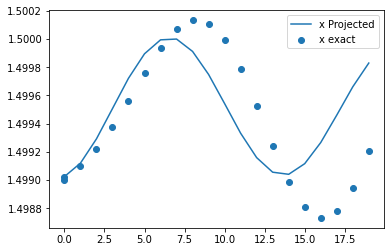

In [81]:
results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,0], label="x Projected")
results = projected_evolution(x=.001, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1, tmax = 20, distance=bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,0], label="x exact")
plt.legend()


In [ ]:
help(qutip.entropy)

Help on module qutip.entropy in qutip:

NAME
    qutip.entropy

FUNCTIONS
    concurrence(rho)
        Calculate the concurrence entanglement measure for a two-qubit state.
        
        Parameters
        ----------
        state : qobj
            Ket, bra, or density matrix for a two-qubit state.
        
        Returns
        -------
        concur : float
            Concurrence
        
        References
        ----------
        
        .. [1] https://en.wikipedia.org/wiki/Concurrence_(quantum_computing)
    
    entangling_power(U)
        Calculate the entangling power of a two-qubit gate U, which
        is zero of nonentangling gates and 1 and 2/9 for maximally
        entangling gates.
        
        Parameters
        ----------
        U : qobj
            Qobj instance representing a two-qubit gate.
        
        Returns
        -------
        ep : float
            The entanglement power of U (real number between 0 and 1)
        
        References:
     

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


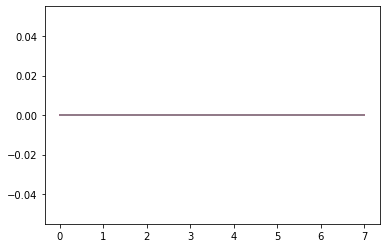

In [ ]:
results = projected_evolution(x=.5, gamma = 1*np.e*-2, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1., tmax = 500., distance=bures)

#plt.plot(results[0], label="x")
plt.plot(results[1], label="p")

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


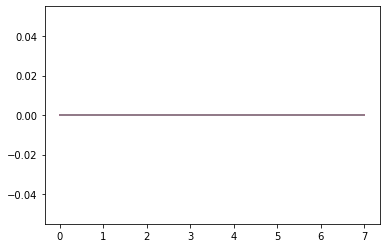

In [ ]:
results = projected_evolution(x=.5, gamma = 1*np.e*-2, omega_1=3., omega_2=3.,temp=1, gaussian=False, deltat=1., tmax = 200., distance=bures)

plt.plot(results, label="p")

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


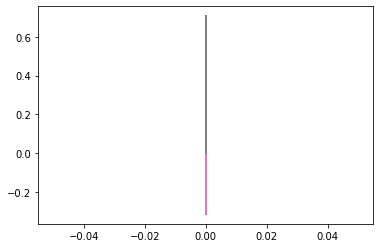

In [ ]:
plt.plot(results, corr_op)

base
<class 'list'> <class 'qutip.qobj.Qobj'>
dim= 2
base
<class 'list'> <class 'qutip.qobj.Qobj'>
dim= 2
base
<class 'list'> <class 'qutip.qobj.Qobj'>
dim= 2


Text(0.5, 1.0, ' BW Dinámica cerrada no gaussiana wb1=3.0 wb2=6.928203230275509')

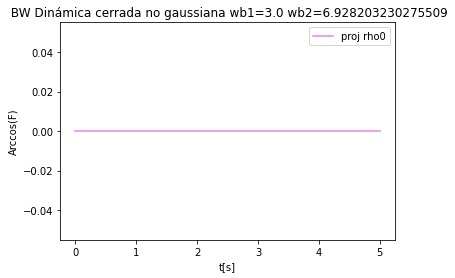

In [ ]:
result, title = projected_evolution(x=.1, gamma = 1*np.e**-2, omega_1=3., omega_2=np.sqrt(48), temp=1, gaussian=True, deltat=5., tmax=10., distance=bures)

plt.plot(result.times, result.projrho0_app, color="violet", label="proj rho0")
plt.xlabel("t[s]")
plt.ylabel("Arccos(F)")

plt.legend()
plt.title(title)

In [ ]:
a=4.2


In [ ]:
math.isnan(3.2)

False

In [ ]:
c_op_list = spin_dephasing(.1)
[type(o) for o in c_op_list]

[qutip.qobj.Qobj,
 qutip.qobj.Qobj,
 qutip.qobj.Qobj,
 qutip.qobj.Qobj,
 qutip.qobj.Qobj]

In [ ]:
rho0 = qutip.tensor([.5*qutip.qeye(2) for k in range(3)])
id5 = .125*qutip.qeye(2**3)
print(rho0)
print(id5)

Quantum object: dims = [[2, 2, 2], [2, 2, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0.125 0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.125 0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.125 0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.125 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.125 0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.125 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.125 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.125]]
Quantum object: dims = [[8], [8]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[0.125 0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.125 0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.125 0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.125 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.125 0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.125 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.125 0.   ]
 [0.    0.    0.    0.    0.    0.    0.  